In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import kagglehub
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Activation
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from scikeras.wrappers import KerasRegressor

# Download dataset
path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")
print("Path to dataset files:", path)

100%|██████████| 23.4k/23.4k [00:00<00:00, 26.7MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/rahulsah06/gooogle-stock-price/versions/1


In [ ]:
# Load dataset
file_path = path  + "/Google_Stock_Price_Train.csv"
df = pd.read_csv(file_path)
print(df.head())
print(df.describe())
df.info()

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
              Open         High          Low
count  1258.000000  1258.000000  1258.000000
mean    533.709833   537.880223   529.007409
std     151.904442   153.008811   150.552807
min     279.120000   281.210000   277.220000
25%     404.115000   406.765000   401.765000
50%     537.470000   540.750000   532.990000
75%     654.922500   662.587500   644.800000
max     816.680000   816.680000   805.140000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   

In [ ]:
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

print("\nCleaned：")
print(df.head())


Cleaned：
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7380500.0
1  1/4/2012  331.27  333.87  329.08  666.45   5749400.0
2  1/5/2012  329.83  330.75  326.89  657.21   6590300.0
3  1/6/2012  328.34  328.77  323.68  648.24   5405900.0
4  1/9/2012  322.04  322.29  309.46  620.76  11688800.0


In [ ]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_features = feature_scaler.fit_transform(df[['Open', 'High', 'Low', 'Volume']])

scaled_close = target_scaler.fit_transform(df[['Close']])
scaled_data = np.concatenate((scaled_features, scaled_close), axis=1)


In [ ]:
# Function to create sequences
def create_sequences(data, N):
    X, y = [], []
    for i in range(N, len(data)):
        X.append(data[i-N:i])  # Features: past N days
        y.append(data[i][-1])  # Target: the next day's 'Close'
    return np.array(X), np.array(y)

# For N=20
N_20 = 20
X_20, y_20 = create_sequences(scaled_data, N_20)

# For N=60
N_60 = 60
X_60, y_60 = create_sequences(scaled_data, N_60)

print(f"X_20 shape: {X_20.shape}, y_20 shape: {y_20.shape}")
print(f"X_60 shape: {X_60.shape}, y_60 shape: {y_60.shape}")

X_20 shape: (1238, 20, 5), y_20 shape: (1238,)
X_60 shape: (1198, 60, 5), y_60 shape: (1198,)


In [ ]:
# Split into training, validation, and test sets
def split_data(X, y, train_size=0.8, val_size=0.1):
    train_end = int(len(X) * train_size)
    val_end = int(len(X) * (train_size + val_size))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

# For N=20
X_train_20, y_train_20, X_val_20, y_val_20, X_test_20, y_test_20 = split_data(X_20, y_20)

# For N=60
X_train_60, y_train_60, X_val_60, y_val_60, X_test_60, y_test_60 = split_data(X_60, y_60)

print(f"Training data for N=20: X_train_20 shape: {X_train_20.shape}, y_train_20 shape: {y_train_20.shape}")
print(f"Validation data for N=20: X_val_20 shape: {X_val_20.shape}, y_val_20 shape: {y_val_20.shape}")
print(f"Test data for N=20: X_test_20 shape: {X_test_20.shape}, y_test_20 shape: {y_test_20.shape}")

print(f"Training data for N=60: X_train_60 shape: {X_train_60.shape}, y_train_60 shape: {y_train_60.shape}")
print(f"Validation data for N=60: X_val_60 shape: {X_val_60.shape}, y_val_60 shape: {y_val_60.shape}")
print(f"Test data for N=60: X_test_60 shape: {X_test_60.shape}, y_test_60 shape: {y_test_60.shape}")

Training data for N=20: X_train_20 shape: (990, 20, 5), y_train_20 shape: (990,)
Validation data for N=20: X_val_20 shape: (124, 20, 5), y_val_20 shape: (124,)
Test data for N=20: X_test_20 shape: (124, 20, 5), y_test_20 shape: (124,)
Training data for N=60: X_train_60 shape: (958, 60, 5), y_train_60 shape: (958,)
Validation data for N=60: X_val_60 shape: (120, 60, 5), y_val_60 shape: (120,)
Test data for N=60: X_test_60 shape: (120, 60, 5), y_test_60 shape: (120,)


In [ ]:
def create_lstm_model(activation='relu', optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=50, activation=activation, input_shape=(None, 5)))  # Changed input_shape to (None, 5)
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

# Similarly, update input_shape for GRU and SimpleRNN models:
def create_gru_model(activation='relu', optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(GRU(units=50, activation=activation, input_shape=(None, 5)))  # Changed input_shape to (None, 5)
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

def create_simplernn_model(activation='relu', optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation=activation, input_shape=(None, 5)))  # Changed input_shape to (None, 5)
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [ ]:
# Function to create KerasRegressor for LSTM
def create_lstm_wrapper():
    return KerasRegressor(model=create_lstm_model, epochs=50, batch_size=32, verbose=0)

# Function to create KerasRegressor for GRU
def create_gru_wrapper():
    return KerasRegressor(model=create_gru_model, epochs=50, batch_size=32, verbose=0)

# Function to create KerasRegressor for SimpleRNN
def create_simplernn_wrapper():
    return KerasRegressor(model=create_simplernn_model, epochs=50, batch_size=32, verbose=0)


In [ ]:
# Define parameter grid for GridSearch
param_grid = {
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'model__learning_rate': [0.001, 0.01],
}

# GridSearch for LSTM with N=20
lstm_model_20 = create_lstm_wrapper()
grid_search_lstm_20 = GridSearchCV(estimator=lstm_model_20, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lstm_20.fit(X_train_20, y_train_20)

# GridSearch for LSTM with N=60
lstm_model_60 = create_lstm_wrapper()
grid_search_lstm_60 = GridSearchCV(estimator=lstm_model_60, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_lstm_60.fit(X_train_60, y_train_60)

# Print best parameters for LSTM with N=20
print("Best parameters for LSTM (N=20):", grid_search_lstm_20.best_params_)

# Print best parameters for LSTM with N=60
print("Best parameters for LSTM (N=60):", grid_search_lstm_60.best_params_)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters for LSTM (N=20): {'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop'}
Best parameters for LSTM (N=60): {'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop'}


In [ ]:

# Get the best model for N=20 and N=60
best_model_20 = grid_search_lstm_20.best_estimator_
best_model_60 = grid_search_lstm_60.best_estimator_

# Make predictions on the test set
y_pred_20 = best_model_20.predict(X_test_20)
y_pred_60 = best_model_60.predict(X_test_60)

# Inverse transform the predictions and true values to get original scale (since MinMax scaling was used)
y_test_20_original = target_scaler.inverse_transform(y_test_20.reshape(-1, 1))
y_pred_20_original = target_scaler.inverse_transform(y_pred_20.reshape(-1, 1))

y_test_60_original = target_scaler.inverse_transform(y_test_60.reshape(-1, 1))
y_pred_60_original = target_scaler.inverse_transform(y_pred_60.reshape(-1, 1))

# Calculate the Mean Squared Error for both models
mse_20 = mean_squared_error(y_test_20_original, y_pred_20_original)
mse_60 = mean_squared_error(y_test_60_original, y_pred_60_original)

print(f'Mean Squared Error for LSTM (N=20): {mse_20}')
print(f'Mean Squared Error for LSTM (N=60): {mse_60}')

# Compare the performance
if mse_20 < mse_60:
    print("LSTM model with N=20 performs better.")
else:
    print("LSTM model with N=60 performs better.")


Mean Squared Error for LSTM (N=20): 316.27050898554205
Mean Squared Error for LSTM (N=60): 90.19420337852732
LSTM model with N=60 performs better.


In [ ]:
best_lstm_model = best_model_60  # Set the best model to N=60

In [ ]:
# GridSearch for GRU with N=20
gru_model_20 = create_gru_wrapper()
grid_search_gru_20 = GridSearchCV(estimator=gru_model_20, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_gru_20.fit(X_train_20, y_train_20)

# GridSearch for GRU with N=60
gru_model_60 = create_gru_wrapper()
grid_search_gru_60 = GridSearchCV(estimator=gru_model_60, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_gru_60.fit(X_train_60, y_train_60)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


GridSearchCV(cv=3,
             estimator=KerasRegressor(batch_size=32, epochs=50, model=<function create_gru_model at 0x7d47d30f0ee0>, verbose=0),
             n_jobs=-1,
             param_grid={'model__activation': ['relu', 'tanh'],
                         'model__learning_rate': [0.001, 0.01],
                         'model__optimizer': ['adam', 'rmsprop']})

In [ ]:
# GridSearch for SimpleRNN with N=20
rnn_model_20 = create_simplernn_wrapper()
grid_search_rnn_20 = GridSearchCV(estimator=rnn_model_20, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rnn_20.fit(X_train_20, y_train_20)

# GridSearch for SimpleRNN with N=60
rnn_model_60 = create_simplernn_wrapper()
grid_search_rnn_60 = GridSearchCV(estimator=rnn_model_60, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search_rnn_60.fit(X_train_60, y_train_60)


In [ ]:
def get_best_model_and_evaluate(grid_search_20, grid_search_60, X_test_20, y_test_20, X_test_60, y_test_60, target_scaler):
    # Get the best models for both N=20 and N=60
    best_model_20 = grid_search_20.best_estimator_
    best_model_60 = grid_search_60.best_estimator_

    # Predict on the test data
    y_pred_20 = best_model_20.predict(X_test_20)
    y_pred_60 = best_model_60.predict(X_test_60)

    # Inverse transform the predictions and true values to get the original scale
    y_test_20_original = target_scaler.inverse_transform(y_test_20.reshape(-1, 1))
    y_pred_20_original = target_scaler.inverse_transform(y_pred_20.reshape(-1, 1))

    y_test_60_original = target_scaler.inverse_transform(y_test_60.reshape(-1, 1))
    y_pred_60_original = target_scaler.inverse_transform(y_pred_60.reshape(-1, 1))

    # Calculate MSE for both models
    mse_20 = mean_squared_error(y_test_20_original, y_pred_20_original)
    mse_60 = mean_squared_error(y_test_60_original, y_pred_60_original)

    print(f'Mean Squared Error for Model with N=20: {mse_20}')
    print(f'Mean Squared Error for Model with N=60: {mse_60}')

    # Compare the performance and return the better model
    if mse_20 < mse_60:
        print("Model with N=20 performs better.")
        return best_model_20
    else:
        print("Model with N=60 performs better.")
        return best_model_60


In [ ]:
best_gru_model = get_best_model_and_evaluate(grid_search_gru_20, grid_search_gru_60, X_test_20, y_test_20, X_test_60, y_test_60, target_scaler)
best_rnn_model = get_best_model_and_evaluate(grid_search_rnn_20, grid_search_rnn_60, X_test_20, y_test_20, X_test_60, y_test_60, target_scaler)


Mean Squared Error for Model with N=20: 136.64952519486258
Mean Squared Error for Model with N=60: 93.5435345409836
Model with N=60 performs better.
Mean Squared Error for Model with N=20: 96.14292919679147
Mean Squared Error for Model with N=60: 312.4843512830019
Model with N=20 performs better.


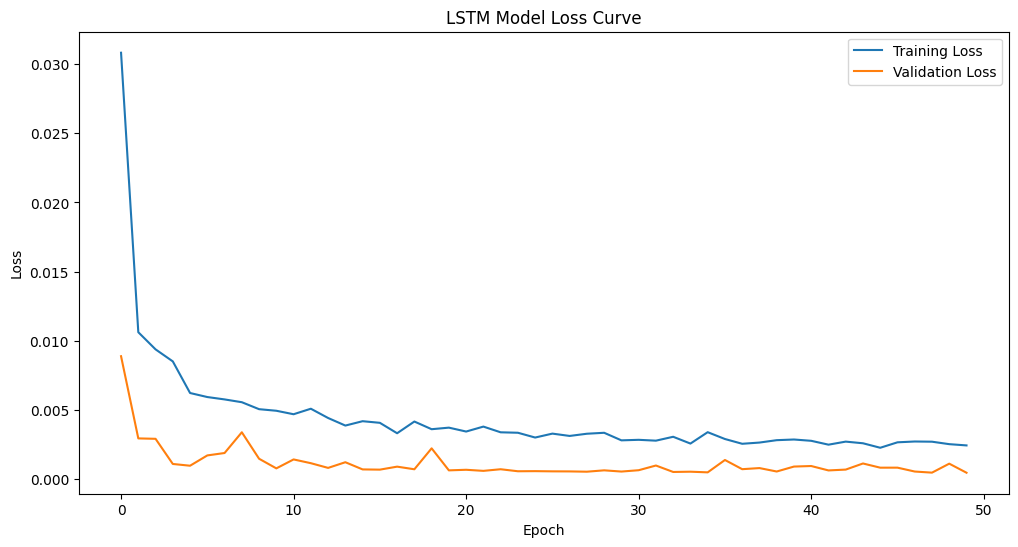

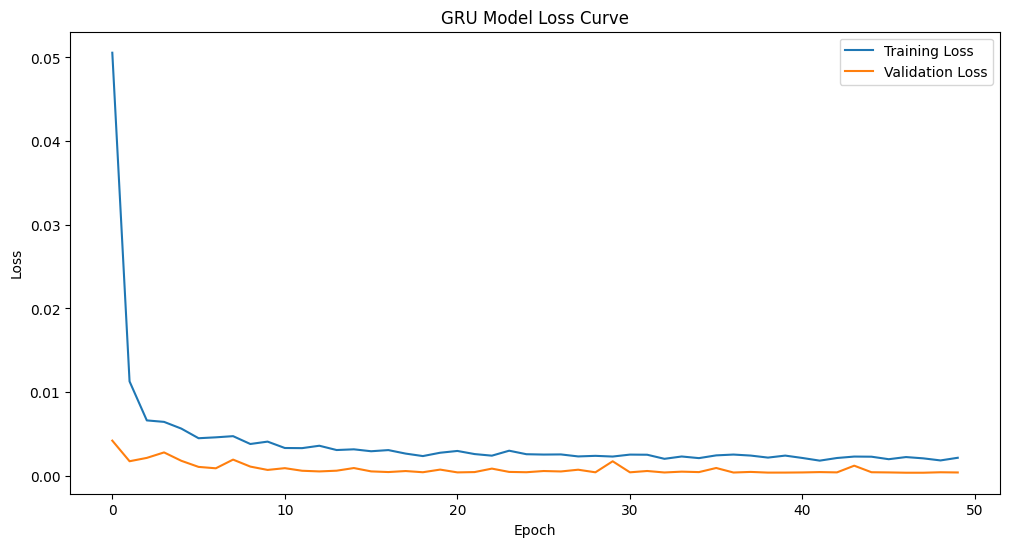

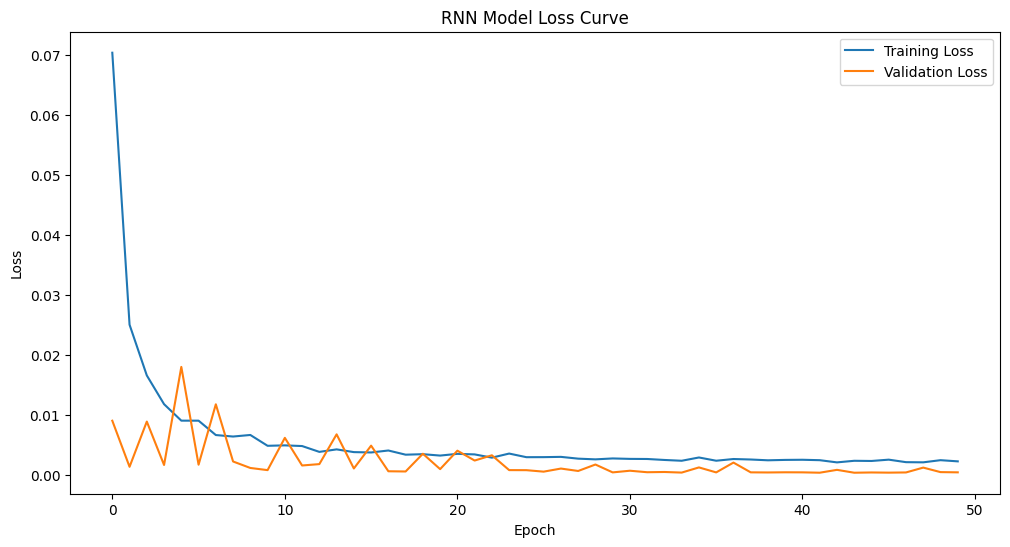

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(estimator, model_name):
    """Plots the loss curve for a KerasRegressor."""
    # Access the underlying Keras model's history
    history = estimator.model_.history

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function with the KerasRegressor and model name
plot_loss_curve(best_lstm_model, 'LSTM Model')

plot_loss_curve(best_gru_model, 'GRU Model')
plot_loss_curve(best_rnn_model, 'RNN Model')

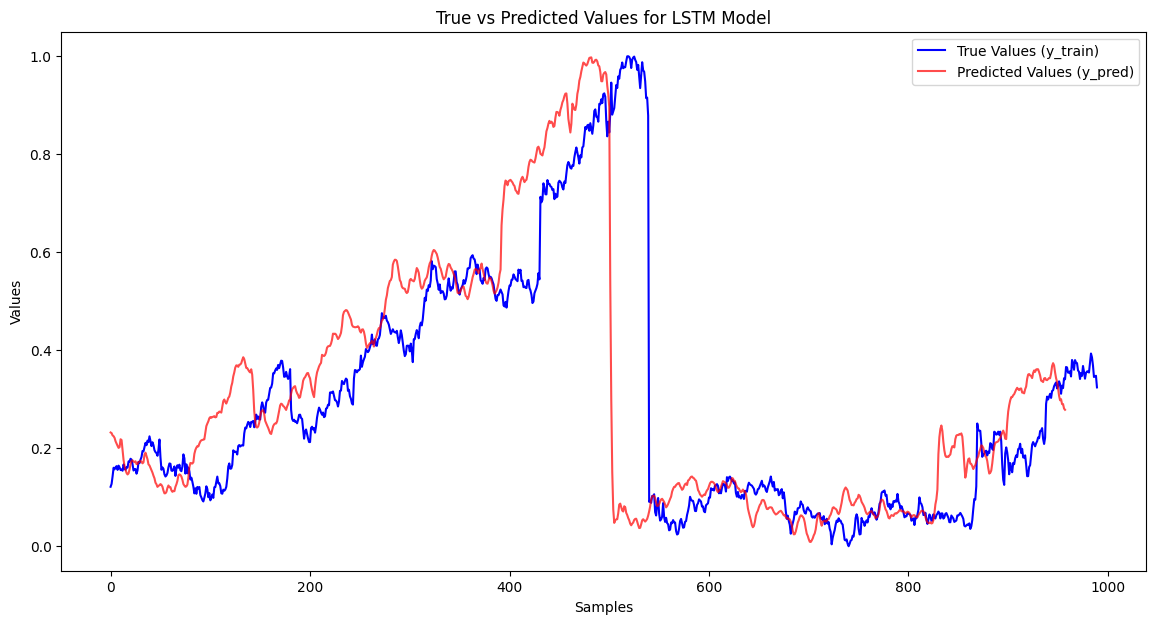

In [ ]:
import matplotlib.pyplot as plt

y_train_pred = best_lstm_model.predict(X_train_60)

plt.figure(figsize=(14, 7))
plt.plot(y_train_20, label='True Values (y_train)', color='blue')
plt.plot(y_train_pred, label='Predicted Values (y_pred)', color='red', alpha=0.7)

plt.title('True vs Predicted Values for LSTM Model')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.show()


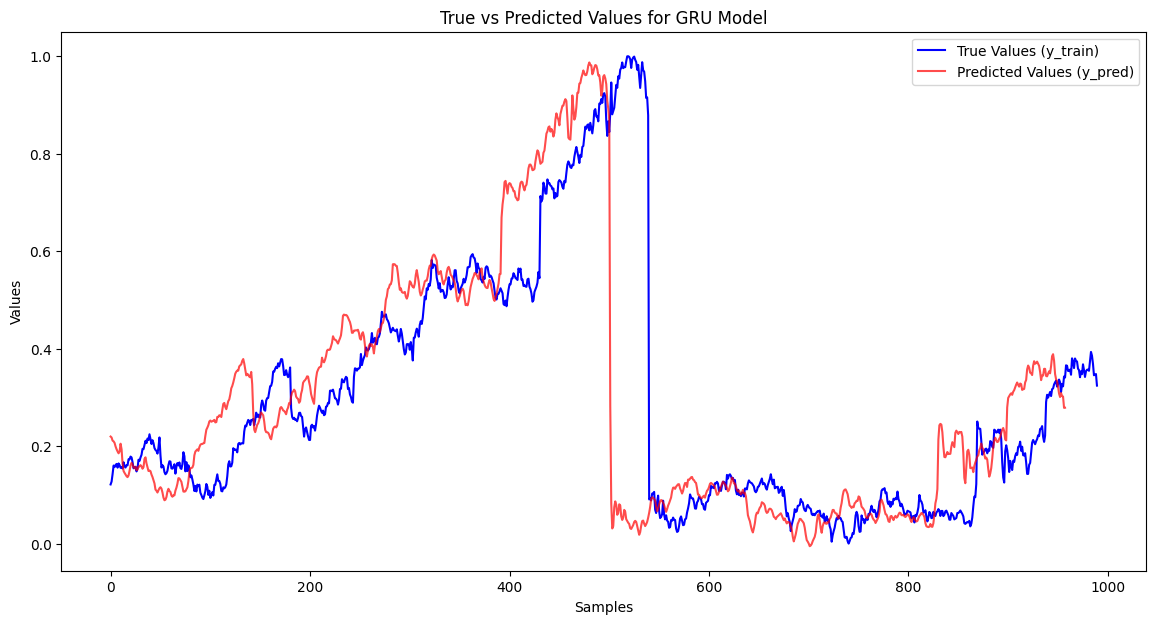

In [ ]:

y_train_pred = best_gru_model.predict(X_train_60)

plt.figure(figsize=(14, 7))
plt.plot(y_train_20, label='True Values (y_train)', color='blue')
plt.plot(y_train_pred, label='Predicted Values (y_pred)', color='red', alpha=0.7)

plt.title('True vs Predicted Values for GRU Model')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.show()


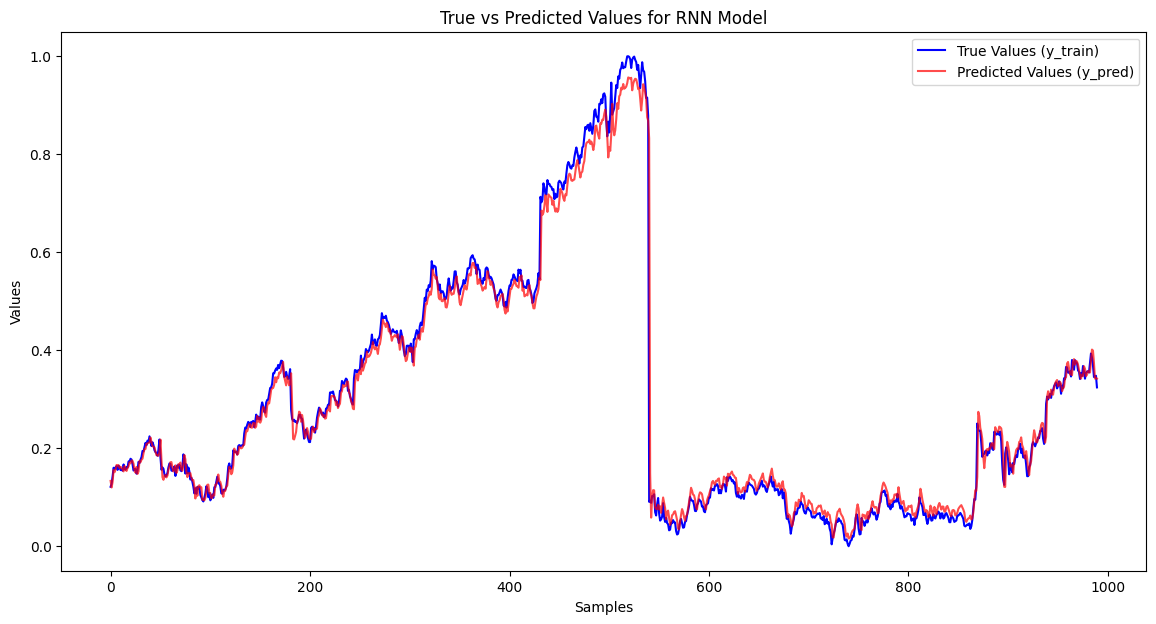

In [ ]:

y_train_pred = best_rnn_model.predict(X_train_20)

plt.figure(figsize=(14, 7))
plt.plot(y_train_20, label='True Values (y_train)', color='blue')
plt.plot(y_train_pred, label='Predicted Values (y_pred)', color='red', alpha=0.7)

plt.title('True vs Predicted Values for RNN Model')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()

plt.show()

In [51]:
print("Best parameters for LSTM model:")
print(grid_search_lstm_20.best_params_)

print("Best parameters for GRU model:")
print(grid_search_gru_20.best_params_)

print("Best parameters for RNN model:")
print(grid_search_rnn_20.best_params_)


Best parameters for LSTM model:
{'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop'}
Best parameters for GRU model:
{'model__activation': 'tanh', 'model__learning_rate': 0.001, 'model__optimizer': 'adam'}
Best parameters for RNN model:
{'model__activation': 'tanh', 'model__learning_rate': 0.01, 'model__optimizer': 'rmsprop'}
